In [2]:
import momepy as mm
import numpy as np
import pandas as pd
from libpysal.graph import Graph
import geopandas as gpd
import pytest
import glob
import shapely
import gc
from shapely import coverage_simplify
import datetime
from libpysal.graph import read_parquet
from utils import lazy_higher_order, partial_apply
import re
import numba
import matplotlib.pyplot as plt
import seaborn as sns
from utils import used_keys, char_units, standardize_features
from sklearn.preprocessing import StandardScaler

regions_datadir = '/data/uscuni-ulce/'
data_dir = '/data/uscuni-ulce/processed_data/'
eubucco_files = glob.glob(regions_datadir + 'eubucco_raw/*')
graph_dir = data_dir + 'neigh_graphs/'
chars_dir = '/data/uscuni-ulce/processed_data/chars/'

In [3]:
region_id = 69300

In [4]:
tessellation = gpd.read_parquet(chars_dir +  f'tessellations/chars_{region_id}.parquet')
buildings = gpd.read_parquet(chars_dir +  f'buildings/chars_{region_id}.parquet')
enclosures = gpd.read_parquet(chars_dir +  f'enclosures/chars_{region_id}.parquet')
streets = gpd.read_parquet(chars_dir +  f'streets/chars_{region_id}.parquet')
nodes = gpd.read_parquet(chars_dir +  f'nodes/chars_{region_id}.parquet')


merged = pd.merge(tessellation.drop(columns=['geometry']), 
          buildings.drop(columns=['nodeID', 'geometry']),
        right_index=True, left_index=True, how='left')

merged = merged.merge(enclosures.drop(columns='geometry'), right_on='eID', left_on='enclosure_index', how='left')

merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

merged = merged.drop(columns=['nID', 'eID', 'nodeID', 'mm_len', 'cdsbool',
                               'node_start', 'node_end', 'x', 'y', 'enclosure_index', 
                               'id', 'osm_id', 'index' ## maybe keep
                               ])
merged = merged.set_index(tessellation.index)

In [5]:
primary = merged[list(used_keys.keys())]

In [46]:
@numba.njit(parallel=True)
def numba_limit_range(rows, cols, partial_vals, output_vals):
    # print(partial_vals)
    ngroups = int(rows[-1])+1
    nrows = rows.shape[0]
    result = np.empty((ngroups, partial_vals.shape[1]*output_vals))

    istart = 0
    for g in range(ngroups):
        
        # # find focal start
        # istart = 0
        # while istart < nrows and rows[istart] != g:
        #     istart += 1

        # find neighbors
        iend = istart + 1
        while iend < nrows and rows[iend-1] == rows[iend]:
            iend += 1
        
        ## for every column apply iqr and percentiles
        for c in numba.prange(partial_vals.shape[1]):

            col_vals = partial_vals[cols[istart:iend], c]
            res_index = output_vals*c
            
            if np.isnan(col_vals).all():
                result[g, res_index] = np.nan
                result[g, res_index+1] = np.nan
                result[g, res_index+2] = np.nan
                result[g, res_index+3] = np.nan
                continue
            
            lower, med, higher = np.nanpercentile(col_vals, (25, 50, 75))
            result[g, res_index] = lower
            result[g, res_index+1] = med
            result[g, res_index+2] = higher
            result[g, res_index+3] = higher - lower
            
            # ## this might be undesired
            # if np.isfinite(col_vals).sum() > 3:
                
            #     mask = np.logical_and(lower <= col_vals, col_vals <= higher)
            #     col_vals = col_vals[mask]
            #     result[g, res_index] = lower
            #     result[g, res_index+1] = higher
            #     result[g, res_index+2] = np.nanmax(col_vals) - np.nanmin(col_vals)
                
            # else:
                
            #     result[g, res_index] = lower
            #     result[g, res_index+1] = higher
            #     result[g, res_index+2] = np.nanmax(col_vals) - np.nanmin(col_vals)

        # # go to next group
        istart = iend
    return result

In [47]:
def parallel_higher_order_context(df, graph, k, n_splits, output_vals):
    A = graph.transform("B").sparse
    ids = graph.unique_ids.values
    rows = np.arange(A.shape[0])
    values = df.values

    final_result = pd.DataFrame(np.empty((values.shape[0], values.shape[1]*output_vals)),
                                index=ids)
    
    for source in np.array_split(rows, n_splits):
   
        Q = A[source, :].copy()
        for _ in range(1, k):
            next_step = Q @ A
            Q += next_step
        
        sparray = Q.tocoo(copy=False)
        sorter = sparray.row.argsort()
        unique_tail = np.unique(sparray.col)
        partial_vals = values[unique_tail, :]

        cols_dict = pd.Series(np.arange(len(unique_tail)), index=unique_tail)
        columns_to_pass = cols_dict.loc[sparray.col].values
        rows_to_pass = sparray.row[sorter]

        partial_res = numba_limit_range(rows_to_pass, columns_to_pass, partial_vals, output_vals)
        
        final_result.iloc[source, :] = partial_res
    
    return final_result

In [18]:
graph = read_parquet(graph_dir + f'tessellation_graph_{region_id}_knn1.parquet')

In [66]:
%%time
context = parallel_higher_order_context(primary, graph, k=5, n_splits=10, output_vals=3)

CPU times: user 9min, sys: 1min 31s, total: 10min 31s
Wall time: 1min 45s


In [67]:
context.columns = np.concatenate([(c+'_lower', c+'_median', c+'_higher') for c in primary.columns])

In [68]:
# context = primary

In [69]:
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)

In [70]:
X_train = X
X_train.shape

(322947, 183)

In [71]:
from cluster_validation import generate_enc_groups, get_tess_groups_original_ilocs
tess_groups = generate_enc_groups(tessellation, enclosures, include_random_sample=True)
tess_groups_ilocs = get_tess_groups_original_ilocs(tessellation, tess_groups)

In [72]:
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from palettable.colorbrewer.qualitative import Set3_12


In [73]:
%%time
reducer = PCA(n_components=50)
embedding = reducer.fit_transform(X_train)

CPU times: user 52.4 s, sys: 2.74 s, total: 55.2 s
Wall time: 3.81 s


In [74]:
davies_bouldin_score(X_train.iloc[tess_groups_ilocs], tess_groups.values)

2.6221873375278895

In [75]:
for n_components in range(2, 50):
    print(n_components, '--', davies_bouldin_score(embedding[tess_groups_ilocs, :n_components], tess_groups.values))

2 -- 3.5523822660689013
3 -- 3.1030132632546437
4 -- 2.2996240500984753
5 -- 2.2990625488226
6 -- 2.358180547930188
7 -- 2.136204281541195
8 -- 2.1668428542883453
9 -- 2.227240993637192
10 -- 2.207685095989478
11 -- 2.1249533123779245
12 -- 2.117294657967877
13 -- 2.1244677021931393
14 -- 2.1284564060453985
15 -- 2.1500526775338944
16 -- 2.1766961839858343
17 -- 2.1837646959895407
18 -- 2.19047673255139
19 -- 2.2073896519915785
20 -- 2.2246876951459074
21 -- 2.2306713412865813
22 -- 2.2378461701646533
23 -- 2.2575266379711647
24 -- 2.2745843818378177
25 -- 2.272804004724287
26 -- 2.2825499009837253
27 -- 2.3072680271049513
28 -- 2.3096444381113255
29 -- 2.322593367823507
30 -- 2.3290976027222774
31 -- 2.334566226323541
32 -- 2.342830201904138
33 -- 2.3632806756152807
34 -- 2.3692230640928598
35 -- 2.377353712250722
36 -- 2.3805914073601775
37 -- 2.39036291976172
38 -- 2.3952661146063616
39 -- 2.401011327306128
40 -- 2.4086488523841356
41 -- 2.421610572650789
42 -- 2.42763038247182
43 -

In [76]:
reducer.explained_variance_ratio_[:5].sum()

0.4269851614699496

In [77]:
embedding_df = pd.DataFrame(embedding[tess_groups_ilocs], index=tess_groups.index)
embedding_df['neighbourhood'] = tess_groups.values

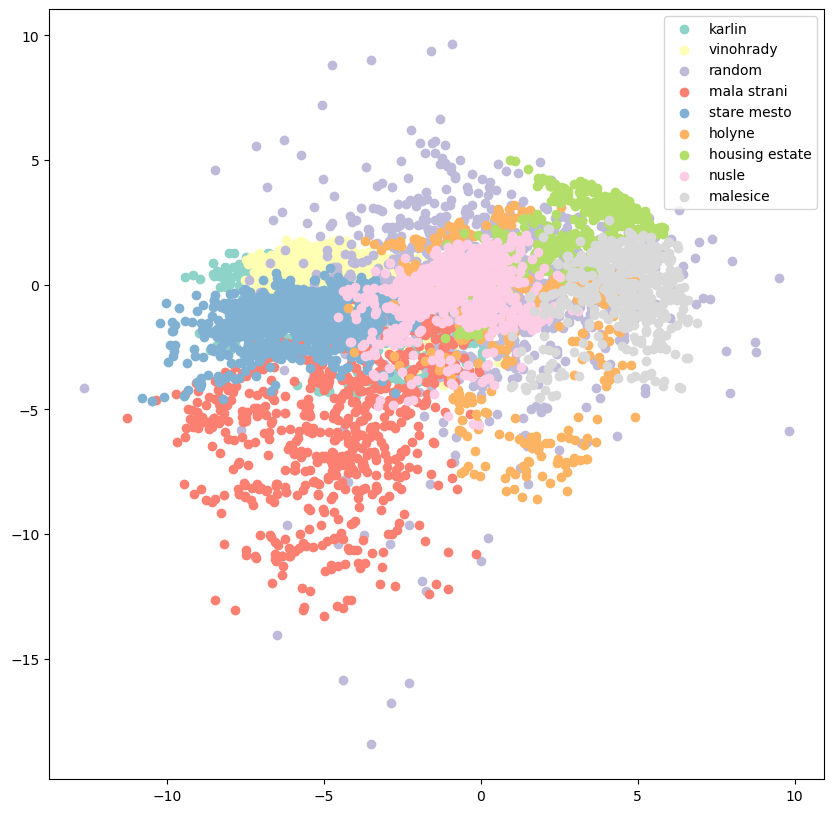

In [65]:

gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby('neighbourhood')
gnames = embedding_df['neighbourhood'].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for genum, gname in zip(genums, gnames):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :10]
    ax.scatter(es_[:,2], es_[:,3], color=color, label=label)
    
ax.legend()

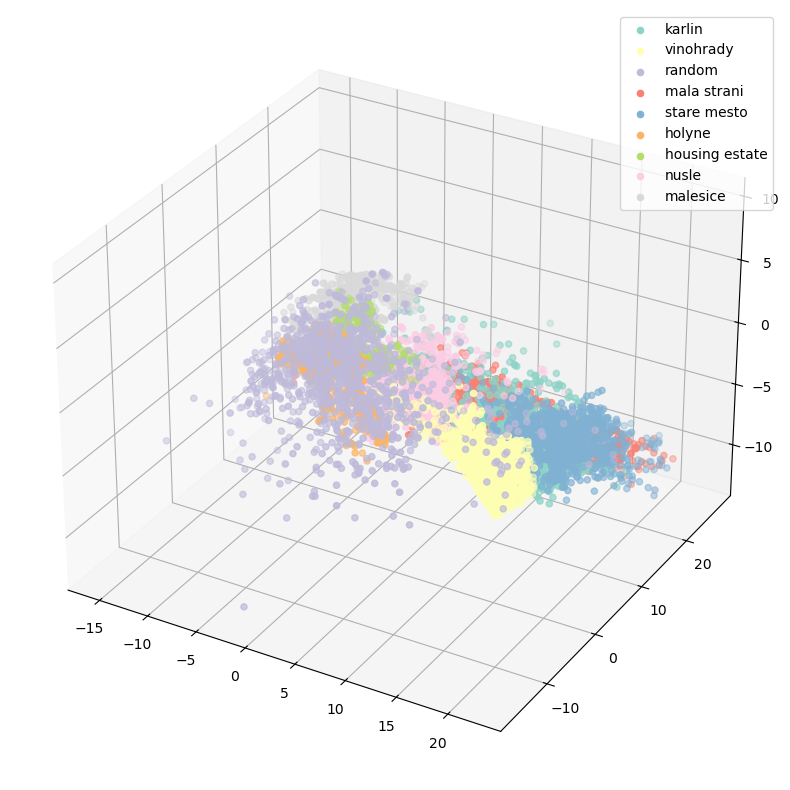

In [60]:

gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby('neighbourhood')
gnames = embedding_df['neighbourhood'].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for genum, gname in zip(genums, gnames):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:,0], es_[:,1], es_[:,2], color=color, label=label)
    
ax.legend()